# Import necessary libraries

In [1]:
from __future__ import unicode_literals, print_function, division

import numpy as np
import pandas as pd
import nltk
from tqdm.autonotebook import tqdm

from io import open
import unicodedata
import re
import string
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nltk.download('punkt')

/tmp/ipykernel_795/1067306592.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read Data

In [2]:
# Read corpus of filename
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        questions = line.split('\t')
        data.append(questions)
        data[-1][-1] = data[-1][-1][:-1]
    return data

# Prepare Data

In [3]:
str_col = ['reference', 'translation']
num_col = ['ref_tox', 'trn_tox', 'similarity', 'lenght_diff']

data = read_corpus("data/raw/filtered.tsv")
data[0][0] = 'id'
for i in range(1, len(data)):
    if float(data[i][-2]) > float(data[i][-1]):
        data[i][-2], data[i][-1] = data[i][-1], data[i][-2]
        data[i][1], data[i][2] = data[i][2], data[i][1]
        
Data = pd.DataFrame(data[1:], columns=data[0])
for num in num_col:
    Data[num] = pd.to_numeric(Data[num])

Data.index = pd.to_numeric(Data['id']).values
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577777 entries, 0 to 577776
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           577777 non-null  object 
 1   reference    577777 non-null  object 
 2   translation  577777 non-null  object 
 3   similarity   577777 non-null  float64
 4   lenght_diff  577777 non-null  float64
 5   ref_tox      577777 non-null  float64
 6   trn_tox      577777 non-null  float64
dtypes: float64(4), object(3)
memory usage: 35.3+ MB


# Prepare Dataloader

In [4]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Vocabulary:
    """
        Vocabulary of words:
            * Initially filled by 3 
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<sos>", 1: "<eos>", 2 : "<pad>"}
        self.n_words = 3

    def addSentence(self, sentence):
        for word in nltk.word_tokenize(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
MAX_LENGTH = 10 # Max length of sentences

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    return nltk.word_tokenize(s)

# Filter pair(toxic text, or translated text) by number of words < MAX_LENGTH
def filterPair(p):
    return len(nltk.word_tokenize(p[0])) < MAX_LENGTH and \
        len(nltk.word_tokenize(p[1])) < MAX_LENGTH


# Filter every pair(toxic text, or translated text) by number of words < MAX_LENGTH
def filter(norm_ref, norm_trs):
    filter_ref = []
    filter_trs = []
    for pair in zip(norm_ref, norm_trs):
        if filterPair(pair):
            filter_ref.append(pair[0])
            filter_trs.append(pair[1])
    return filter_ref, filter_trs


# Create vocabulary for toxic text and translated, also pair of them
def prepareData(data):
    # Normalize every data and filter
    norm_ref = [row for row in data['reference']]
    norm_trs = [row for row in data['translation']]
    
    norm_ref, norm_trs = filter(norm_ref, norm_trs)
    # Make Vocabulary instances
    vocab_tox = Vocabulary('tox-vocab')
    vocab_detox = Vocabulary('detox-vocab')
    pairs = []
    for row in zip(norm_ref, norm_trs):
        pairs.append(row)

    for row in norm_ref:
        vocab_tox.addSentence(row)

    for row in norm_trs:
        vocab_detox.addSentence(row)

    print("Counted words:")
    print(vocab_tox.name, vocab_tox.n_words)
    print(vocab_detox.name, vocab_detox.n_words)

    return vocab_tox, vocab_detox, pairs

In [6]:
# Convert every word in sentence to indexes of vocabulary
def indexesFromSentence(vocab, sentence):
    return [vocab.word2index[word] for word in nltk.word_tokenize(sentence)]

# Convert every word in sentence to indexes of vocabulary in tensor format
def tensorFromSentence(vocab, sentence):
    indexes = indexesFromSentence(vocab, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

# Convert every word in pair sentences to indexes of vocabulary in tensor format
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(vocab_tox, pair[0])
    target_tensor = tensorFromSentence(vocab_detox, pair[1])
    return (input_tensor, target_tensor)


def get_dataloader(batch_size, vocab_tox, vocab_detox, pairs, train_size=0.9):
    """
        Return dataloaders of data pairs by given parameters:
            :param batch_size: dataloader of batch_size
            :param vocab_tox: vocabulary for toxic text
            :param vocab_detox: vocabulary for translated text
            :param pairs: data to create dataloader
            :param train_size: proportion for train part
    """
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH + 1), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH + 1), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(vocab_tox, inp)
        tgt_ids = indexesFromSentence(vocab_detox, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        while len(inp_ids) < MAX_LENGTH + 1:
            inp_ids.append(PAD_token)
        
        while len(tgt_ids) < MAX_LENGTH + 1:
            tgt_ids.append(PAD_token)
        
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    idx = [i for i in range(n)]
    train_idx, val_idx = train_test_split(idx, train_size=train_size, random_state=420)
    train_data = TensorDataset(torch.LongTensor(input_ids[train_idx]).to(device),
                               torch.LongTensor(target_ids[train_idx]).to(device))
    val_data = TensorDataset(torch.LongTensor(input_ids[val_idx]).to(device),
                               torch.LongTensor(target_ids[val_idx]).to(device))
    

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader

# Architecture of seq2seq model

In [68]:
class Encoder(nn.Module):
    """
        Encoder part
    """
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        """
            :param input_size:  number of possible initial words
            :param hidden_size: number of features in the hidden state
            :param dropout_p:   probability for dropout
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD_token)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=2, dropout=dropout_p, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden
    
class Decoder(nn.Module):
    """
        Decoder part
    """
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        """
            :param hidden_size:  number of features in the hidden state
            :param output_size:  number of possible result words
            :param dropout_p:    probability for dropout
        """
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD_token)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=2, dropout=dropout_p, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        
        for i in range(MAX_LENGTH + 1):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        
        return output, hidden

In [69]:
class seq2seq(nn.Module):
    """
        seq2seq model
    """
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1):
        """
            :param input_size:   number of possible initial words
            :param hidden_size:  number of features in the hidden state
            :param output_size:  number of possible result words
            :param dropout_p:    probability for dropout
        """
        super(seq2seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, dropout_p)
        self.decoder = Decoder(hidden_size, output_size, dropout_p)
        
    def forward(self, input, target=None):
        encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_outputs = self.decoder(encoder_outputs, encoder_hidden, target)
        return decoder_outputs
        

# Train model

In [52]:
def train_epoch(epoch, dataloader, seq2seq, optimizer, criterion):

    total_loss = 0
    total = 0
    loop = tqdm(
        enumerate(dataloader, 1),
        total=len(dataloader),
        desc=f"Epoch {epoch}: train",
        leave=True,
    )
    
    seq2seq.train()
    for i, batch in loop:
        input, target = batch

        optimizer.zero_grad()
        
        outputs = seq2seq(input, target)
        loss = criterion(
            outputs.view(-1, outputs.size(-1)),
            target.view(-1)
        )
        loss.backward()

        optimizer.step()

        total_loss += loss.item() * input.shape[0]
        total += input.shape[0]
        loop.set_postfix({"loss": total_loss/total})

    return total_loss / total

In [53]:
def val_epoch(epoch, dataloader, seq2seq,
          criterion, best_so_far=0.0, seq2seq_path='seq2seq.pt'):
    
    total_loss = 0
    total = 0
    loop = tqdm(
        enumerate(dataloader, 1),
        total=len(dataloader),
        desc=f"Epoch {epoch}: val",
        leave=True,
    )
    
    with torch.no_grad():
        seq2seq.eval()
        for i, batch in loop:
            input, target = batch

            outputs = seq2seq(input, target)
            loss = criterion(
                outputs.view(-1, outputs.size(-1)),
                target.view(-1)
            )

            total_loss += loss.item() * input.shape[0]
            total += input.shape[0]
            loop.set_postfix({"loss": total_loss/total})

        Loss = total_loss / total
        if Loss < best_so_far:
            torch.save(seq2seq.state_dict(), seq2seq_path)
            return Loss, total_loss / total

    return best_so_far, total_loss / total

In [46]:
def train(train_dataloader, seq2seq, optimizer, criterion, epochs):
    total = 0
    loss_total = 0
    best = float('inf')
    loss_train_list = []
    loss_val_list = []
    for epoch in range(1, epochs + 1):
        loss_train = train_epoch(epoch, train_dataloader, seq2seq, optimizer, criterion)
        best, loss_val = val_epoch(epoch, val_dataloader, seq2seq, criterion, best_so_far=best)
        loss_train_list.append(loss_train)
        loss_val_list.append(loss_val)
    
    return loss_train_list, loss_val_list

In [12]:
epochs = 15
hidden_size = 128
batch_size = 32
learning_rate = 1e-3

vocab_tox, vocab_detox, pairs = prepareData(Data)
train_dataloader, val_dataloader = get_dataloader(batch_size, vocab_tox, vocab_detox, pairs)

Counted words:
tox-vocab 42485
detox-vocab 35956


In [58]:
seq2seq_model = seq2seq(vocab_tox.n_words, hidden_size, vocab_detox.n_words).to(device)
optimizer = optim.Adam(seq2seq_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

loss_train, loss_val = train(train_dataloader, seq2seq_model, optimizer, criterion, 10)

Epoch 1: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 1: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 2: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 2: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 3: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 3: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 4: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 4: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 5: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 5: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 6: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 6: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 7: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 7: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 8: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 8: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 9: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 9: val:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch 10: train:   0%|          | 0/6035 [00:00<?, ?it/s]

Epoch 10: val:   0%|          | 0/671 [00:00<?, ?it/s]

# Plot loss

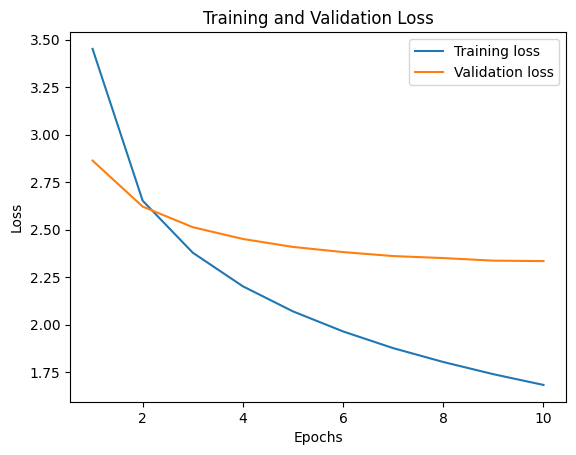

In [60]:
plt.plot(range(1, epochs + 1), loss_train, label='Training loss')
plt.plot(range(1, epochs + 1), loss_val, label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

# Check in random sample from dataset

In [64]:
def evaluate(seq2seq, sentence, vocab_tox, vocab_detox):
    with torch.no_grad():
        seq2seq.eval()
        input_tensor = tensorFromSentence(vocab_tox, sentence)

        outputs = seq2seq(input_tensor)

        _, topi = outputs.topk(1)
        ids = topi.squeeze()

        words = []
        for idx in ids:
            if idx.item() == EOS_token:
                break
            words.append(vocab_detox.index2word[idx.item()])
    return words

In [65]:
def evaluateRandomly(seq2seq, vocab_tox, vocab_detox, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('origin:     ', pair[0])
        print('translated: ', pair[1])
        output_words = evaluate(seq2seq, pair[0], vocab_tox, vocab_detox)
        output_sentence = "".join([" "+i if not i.startswith("'") and not i.startswith("n'") and i not in string.punctuation else i for i in output_words]).strip()
        print('predicted:  ', output_sentence)
        print('')

In [67]:
ckpt_seq2seq = torch.load("seq2seq.pt")
load_seq2seq = seq2seq(vocab_tox.n_words, hidden_size, vocab_detox.n_words).to(device)
load_seq2seq.load_state_dict(ckpt_seq2seq)


load_encoder.eval()
load_decoder.eval()
evaluateRandomly(load_seq2seq, vocab_tox, vocab_detox)

origin:      Cash, be quiet.
translated:  cash, shut up.
predicted:   shut up, please.

origin:      the rat.
translated:  The rat man.
predicted:   That rat rat is a rat.

origin:      I don't remember.
translated:  I don't remember shit.
predicted:   I don't remember that shit.

origin:      You pulled it out, girl!
translated:  you fucked them up, girl!
predicted:   you screwed up, boy!

origin:      I was up for him all night.
translated:  Damn thing kept me up all night.
predicted:   I was all fucked up for night.

origin:      hell, almost perfect.
translated:  Damn near perfect.
predicted:   Damn, that's perfect, perfect.

origin:      general White Phoenix!
translated:  Oh... White General!
predicted:   General White ... White!

origin:      Different dog, same poop.
translated:  different house, but same shit.
predicted:   a baby, you're a figment.

origin:      The troll focused.
translated:  the troll zoomed.
predicted:   the troll studied the troll.

origin:      now ride w